### Import Package

In [182]:
import pandas as pd
import quantstats as qs
import numpy as np
import talib
import ray
import random 

from core.system import *
from core.operation import *
from fredapi import Fred
from pandas.tseries.offsets import BDay

import warnings

warnings.filterwarnings('ignore')

### Data

In [183]:
# Create multi index
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['ticker', 'date'])
    return multi_index_factor

In [184]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')

In [259]:
# Price Data
sp500_tickers = ['AAPL', 'MSFT', 'JNJ', 'WMT', 'PG', 'JPM', 'V', 'UNH', 'INTC', 'T', 'CSCO', 'PFE', 'HD', 'BA', 'XOM', 'CVX', 'KO', 'MCD', 'GS', 'MMM', 'AMZN', 'BRK.B', 'GE', 'IBM', 'DIS', 'PEP', 'MRK', 'GOOGL', 'GOOG', 'BAC', 'C', 'ORCL', 'CMCSA', 'PM', 'SLB', 'WFC', 'VZ', 'ABT', 'MO', 'MDT', 'AXP', 'UTX', 'HON', 'ACN', 'TMO', 'UNP', 'QCOM', 'LMT', 'SBUX', 'F', 'GM', 'CAT', 'DHR', 'NKE', 'ADBE', 'NFLX', 'CRM', 'NVDA', 'LLY', 'BMY', 'CI', 'AET', 'ANTM', 'GILD', 'AMGN', 'TXN', 'USB', 'PNC', 'BLK', 'TJX', 'ADP', 'BK', 'CL', 'SYK', 'SO', 'DUK', 'EXC', 'NEE', 'AEP', 'PGR', 'ALL', 'MET', 'PRU', 'AIG', 'TRV', 'HIG', 'CB', 'SCHW', 'SPGI', 'MMC', 'AON', 'MCK', 'ABC', 'CVS', 'CAH', 'WBA', 'BAX', 'BDX', 'AVGO', 'PYPL']
price_data = get_data_fmp(ticker_list=sp500_tickers, start=start, current_date=current_date)
price_data['Close'] = price_data['Adj Close']
price_data = price_data[['Close']]

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07ticker/s]


In [260]:
# Risk Free Rate
rf = pd.read_parquet(get_parquet(live) / 'data_rf.parquet.brotli')
rf = rf.ffill()
rf = create_multi_index(rf, sp500_tickers)
rf.index.names = ['ticker', 'date']

In [261]:
# Merge Data
price_data = price_data.merge(rf, left_index=True, right_index=True, how='left')
price_data = price_data
price_data['RF'] = price_data.groupby('ticker')['RF'].ffill()

### Create Metrics

In [344]:
def compound_returns(x, window):
    return (1 + x).rolling(window).apply(lambda y: y.prod() - 1, raw=True)

### Strategy

In [403]:
# Params
lookback_period = 252
hold_period = 21

In [404]:
# Create returns and get compound excess return
price_data_copy = price_data.copy(deep=True)
daily_data = create_return(price_data_copy, [1])
daily_data['excess_ret'] = daily_data['RET_01'] - (daily_data['RF']/1000)
daily_data['cum_ret_excess'] = daily_data.groupby('ticker')['excess_ret'].transform(lambda x: compound_returns(x, lookback_period))
daily_data = daily_data[['Close', 'RET_01', 'cum_ret_excess']]
daily_data = daily_data.dropna()

In [405]:
# Calculate Ex Ante Volatility
def calc_ex_ante_vol(group):
    center_mass = 60
    annual = 252
    avg_ret = group['RET_01'].ewm(com=center_mass).mean()  # Exponentially weighted average return
    squared_deviation = (group['RET_01'] - avg_ret) ** 2  # Squared deviations from the mean return
    ewma_variance = squared_deviation.ewm(com=center_mass).mean()  # EWMA of squared deviations
    annualized_variance = ewma_variance * annual  # Annualized variance
    return annualized_variance

daily_data['ex_ante_vol'] = daily_data.groupby('ticker').apply(calc_ex_ante_vol).reset_index(level=0, drop=True)

In [406]:
daily_data['ex_ante_vol'] = daily_data.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(5).std().shift(1))

In [407]:
# Create periods
unique_date = daily_data.index.get_level_values('date').unique()
port_period = {}
count = 1
for date in unique_date:
    if count>hold_period:
        count = 1
    port_period[date] = count
    count+=1 

daily_data['port_period'] = daily_data.index.get_level_values('date').map(port_period)

In [408]:
# Create portfolio per period
period_data = daily_data.reset_index().set_index(['port_period', 'ticker', 'date']).sort_index(level=['port_period', 'ticker', 'date']) 

In [409]:
# Get weight per period
period_data['signal'] = np.sign(period_data['cum_ret_excess'])

In [410]:
# Get weight per period
period_data['weight'] = period_data['signal'] * (1/period_data['ex_ante_vol'])

In [411]:
# Get weight
weight = period_data[['weight']]

In [412]:
# Unstack weight and rename columns
weight = weight.unstack('port_period').sort_index(level=['ticker', 'date'])
weight.columns = [f'period_{period}' for name, period in weight.columns]

In [413]:
# Forward Fill weight per permno (these are the daily weights per period!)
weight = weight.groupby('ticker').ffill()

In [414]:
# Drop NAN values so that all periods start at the same time
weight = weight.dropna()

In [415]:
# Calculate average weights across periods
weight = weight.sum(axis=1).to_frame('total_weight')

In [416]:
# Merge with daily return and volatility
portfolio = pd.merge(weight, daily_data[['ex_ante_vol', 'RET_01']], left_index=True, right_index=True, how='left')

In [417]:
# Normalize total_weight per date
norm_weight = portfolio.groupby(['date'])['total_weight'].transform(lambda x: x.abs().sum())
portfolio['norm_weight'] = portfolio['total_weight']/norm_weight

In [418]:
# Shift returns per stock
portfolio['shift_ret'] = portfolio.groupby('ticker')['RET_01'].shift(-1)

In [419]:
# Calculate strategy return per stock
portfolio['strat_ret'] = portfolio['shift_ret'] * portfolio['norm_weight']

In [420]:
# Calculate strategy return per date 
tsmom = portfolio.groupby('date')['strat_ret'].sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2006-02-09   2006-02-09
End Period                 2024-02-01   2024-02-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          286.35%      87.73%
CAGR﹪                     5.32%        2.45%

Sharpe                     0.48         0.34
Prob. Sharpe Ratio         97.88%       92.09%
Smart Sharpe               0.42         0.3
Sortino                    0.67         0.45
Smart Sortino              0.59         0.4
Sortino/√2                 0.48         0.32
Smart Sortino/√2           0.42         0.28
Omega                      1.07         1.07

Max Drawdown               -56.47%      -38.86%
Longest DD Days            1982         1813
Volatility (ann.)          19.74%       12.88%
R^2                        0.0          0.0
Information Ratio          -0.01        -0.01
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-11-20,2009-10-29,2013-11-06,1813,-38.864853,-38.196485
2,2020-02-14,2021-03-03,2024-02-01,1449,-26.852113,-25.573389
3,2008-10-27,2008-11-03,2008-11-17,22,-14.423891,-11.556817
4,2018-01-26,2018-02-07,2018-08-27,214,-9.153227,-7.736424
5,2008-10-10,2008-10-10,2008-10-23,14,-8.615845,-8.069419


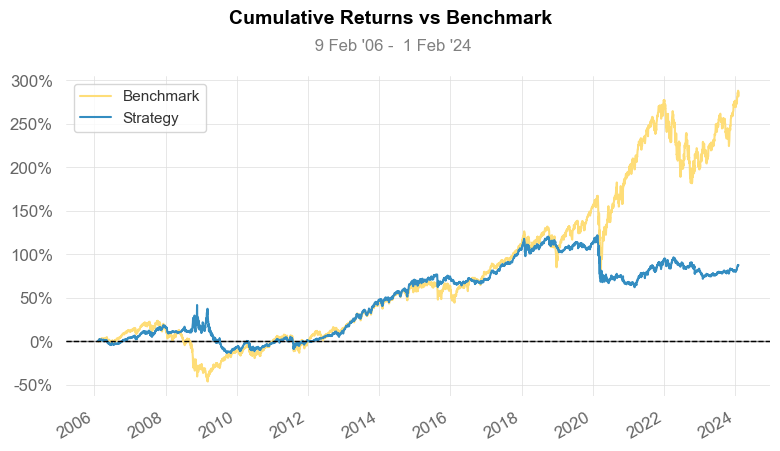

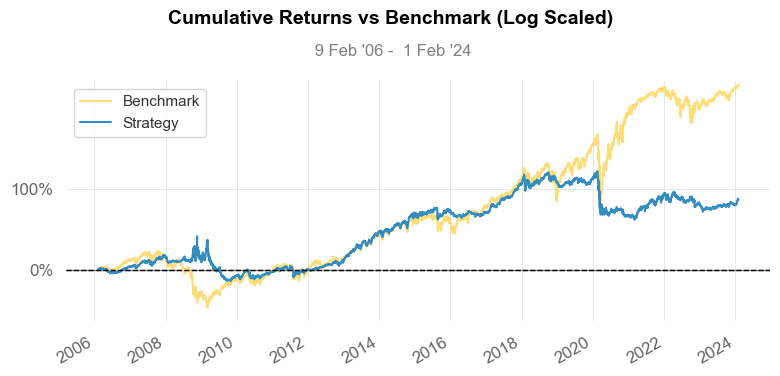

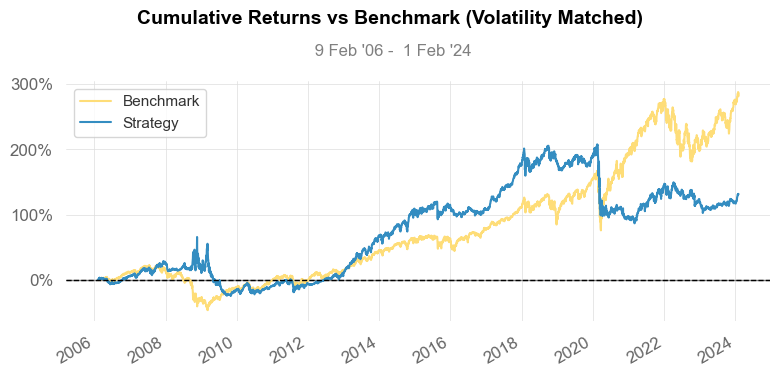

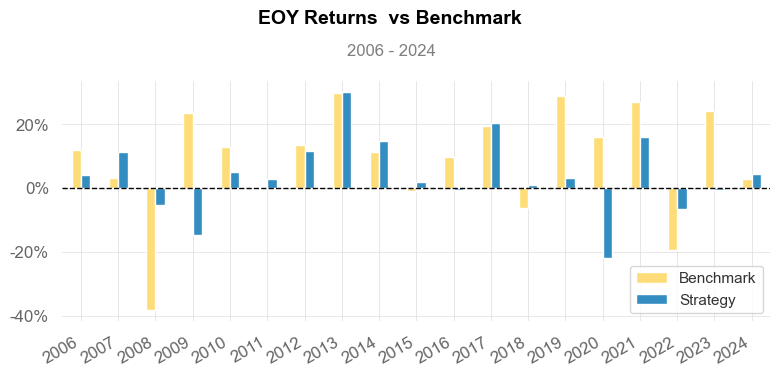

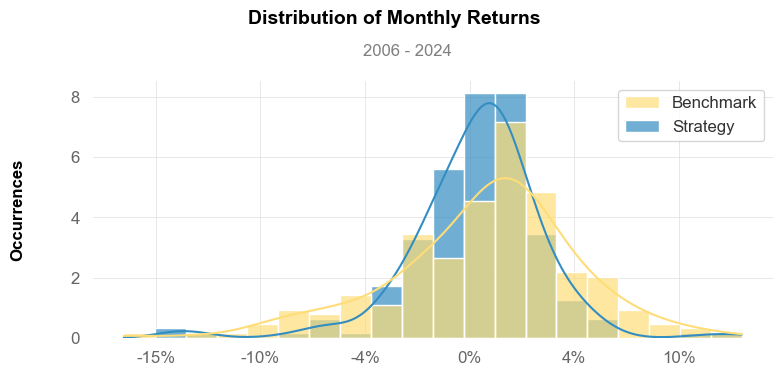

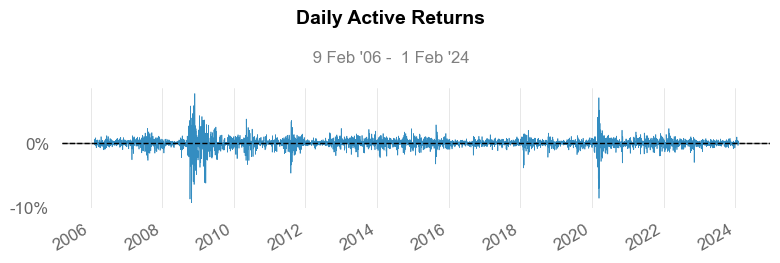

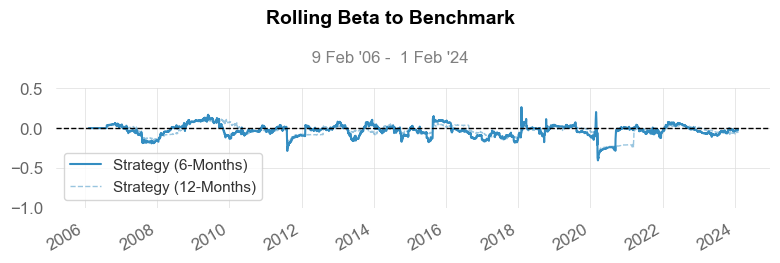

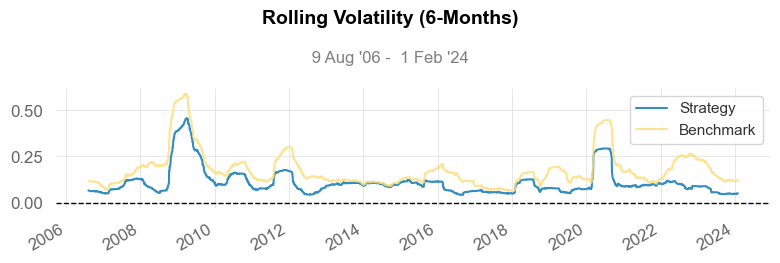

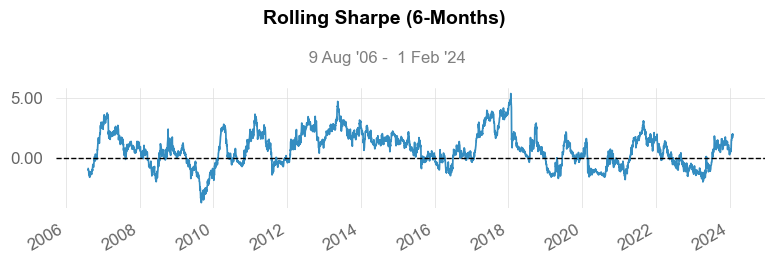

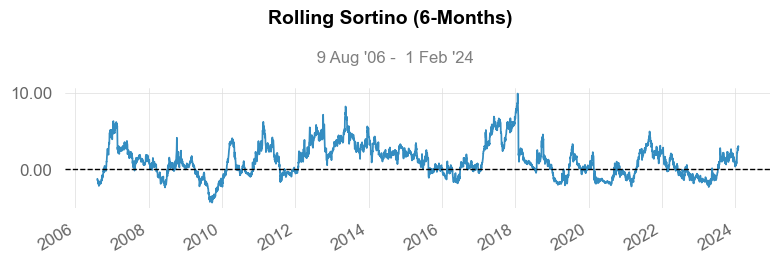

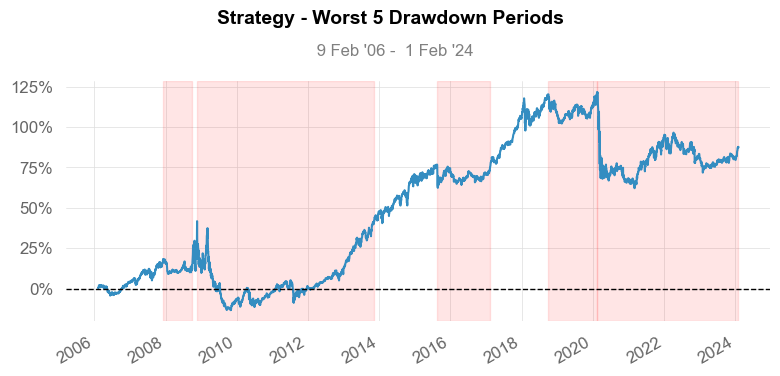

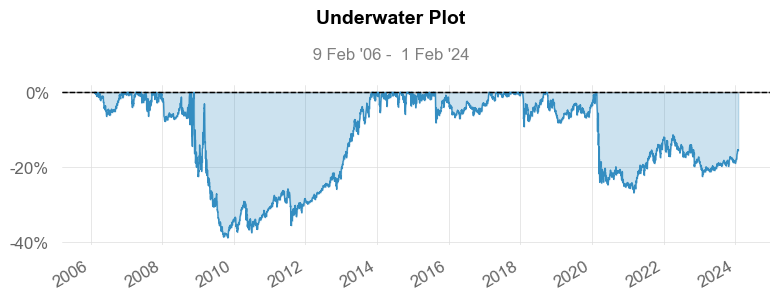

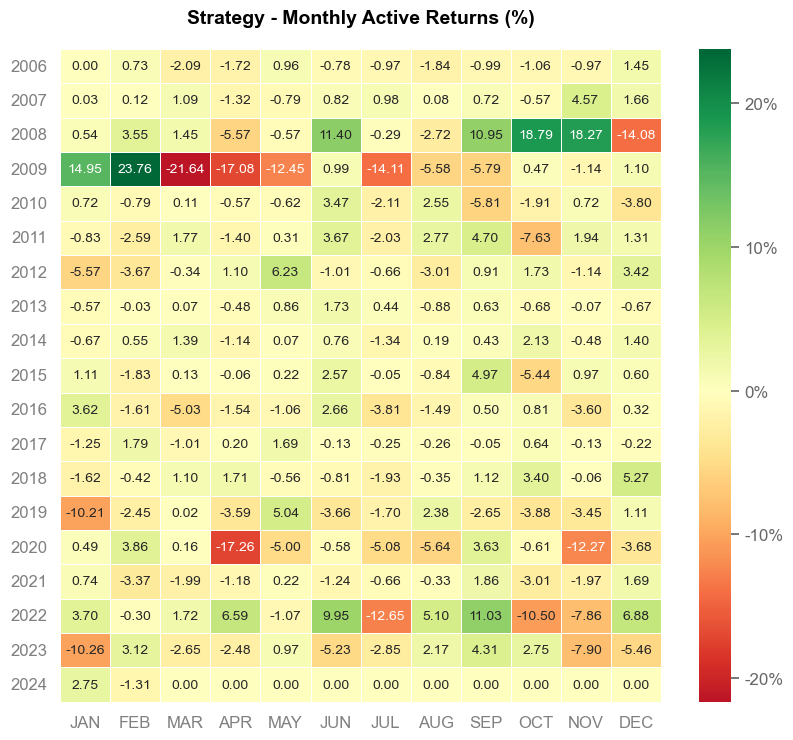

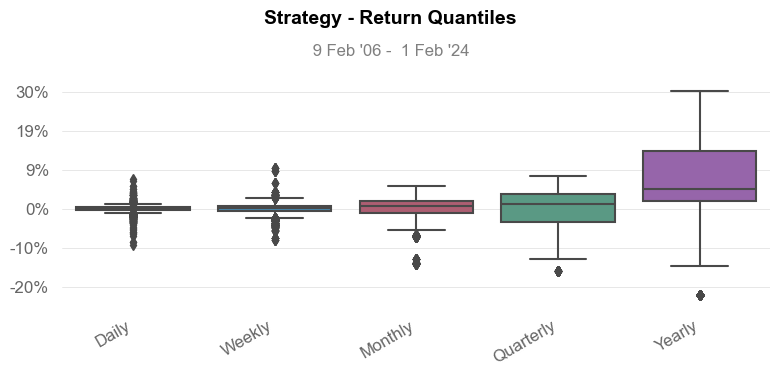

In [421]:
# Backtest
qs.reports.full(tsmom, 'SPY')